In [1]:
!git clone https://github.com/navpreetsingh9/S10-Assignment-Solution.git

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import warnings
warnings.filterwarnings('ignore')

In [3]:
from cifar10.transforms import CustomResnetTransforms
from cifar10.dataloader import Cifar10SearchDataset

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

In [5]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

  0%|                                                                                    | 0/170498071 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:20<00:00, 8200899.79it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=512)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [7]:
from cifar10.utils import show_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


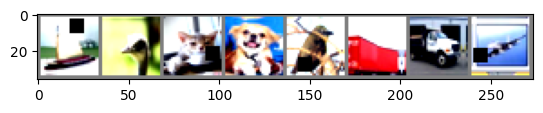

ship  bird  cat   dog  


In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_images(train_loader, classes)

In [9]:
from cifar10.model import CustomResNet
from cifar10.utils import print_summary, get_lr, get_device

In [10]:
_, device = get_device()
model = CustomResNet().to(device)
print_summary(model, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CustomResNet                             [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 64, 32, 32]           128
│    └─Dropout: 2-4                      [1, 64, 32, 32]           --
├─ResNetBlock: 1-2                       [1, 128, 16, 16]          --
│    └─Sequential: 2-5                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          73,728
│    │    └─MaxPool2d: 3-2               [1, 128, 16, 16]          --
│    │    └─ReLU: 3-3                    [1, 128, 16, 16]          --
│    │    └─BatchNorm2d: 3-4             [1, 128, 16, 16]          256
│    │    └─Dropout: 3-5                 [1, 128, 16, 16]          --
│    └

In [11]:
from cifar10.train import train, test

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


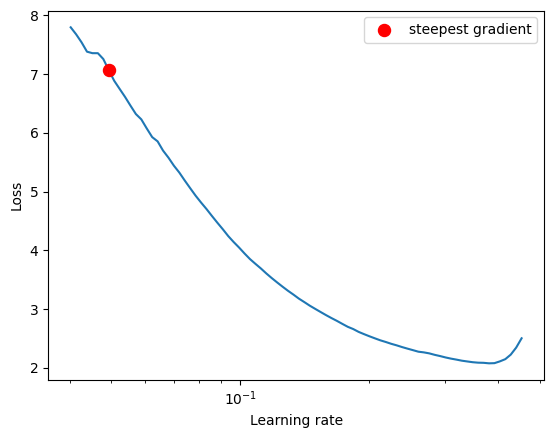

In [12]:
from torch_lr_finder import LRFinder

model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [13]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 24

scheduler = OneCycleLR(
        optimizer,
        max_lr=4.93E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2392, Accuracy: 5769/10000 (57.69%)

EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9779, Accuracy: 6713/10000 (67.13%)

EPOCH: 2


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7996, Accuracy: 7325/10000 (73.25%)

EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6511, Accuracy: 7798/10000 (77.98%)

EPOCH: 4


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9598, Accuracy: 6850/10000 (68.50%)

EPOCH: 5


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7628, Accuracy: 7406/10000 (74.06%)

EPOCH: 6


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7065, Accuracy: 7508/10000 (75.08%)

EPOCH: 7


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6621, Accuracy: 7702/10000 (77.02%)

EPOCH: 8


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9314, Accuracy: 6937/10000 (69.37%)

EPOCH: 9


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6332, Accuracy: 7887/10000 (78.87%)

EPOCH: 10


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6243, Accuracy: 7926/10000 (79.26%)

EPOCH: 11


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8692, Accuracy: 7138/10000 (71.38%)

EPOCH: 12


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5660, Accuracy: 8132/10000 (81.32%)

EPOCH: 13


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5776, Accuracy: 7994/10000 (79.94%)

EPOCH: 14


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5418, Accuracy: 8127/10000 (81.27%)

EPOCH: 15


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5317, Accuracy: 8150/10000 (81.50%)

EPOCH: 16


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4671, Accuracy: 8418/10000 (84.18%)

EPOCH: 17


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4434, Accuracy: 8498/10000 (84.98%)

EPOCH: 18


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4409, Accuracy: 8469/10000 (84.69%)

EPOCH: 19


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4155, Accuracy: 8594/10000 (85.94%)

EPOCH: 20


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3791, Accuracy: 8730/10000 (87.30%)

EPOCH: 21


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3408, Accuracy: 8824/10000 (88.24%)

EPOCH: 22


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2842, Accuracy: 9029/10000 (90.29%)

EPOCH: 23


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.2608, Accuracy: 9122/10000 (91.22%)

